In [ ]:
#!unzip "drive/My Drive/ML Projects/Plant Pathology/plant-pathology-2020-fgvc7 (1).zip" -d"drive/My Drive/ML Projects/Plant Pathology"

In [ ]:
#!pip install -q efficientnet

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
#import efficientnet.tfkeras as efn
#from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 2048
seed_everything(seed)
print("REPLICAS: ", strategy.num_replicas_in_sync)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 40
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

REPLICAS:  1


In [ ]:
train= pd.read_csv('drive/My Drive/ML Projects/Plant Pathology/train.csv')
test = pd.read_csv('drive/My Drive/ML Projects/Plant Pathology/test.csv')
sub= pd.read_csv('drive/My Drive/ML Projects/Plant Pathology/sample_submission.csv')
images = "drive/My Drive/ML Projects/Plant Pathology/images"

In [ ]:
train["image_id"]= train["image_id"]+".jpg"

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [ ]:
X_train, X_valid = train_test_split(train, test_size=0.2, shuffle=False)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,  # Rescaling Image
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
                  X_train,
                  images,
                  x_col='image_id',
                  y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] , 
                  target_size=(256, 256), 
                  class_mode='raw',
                  batch_size=20, 
                  shuffle=True
)

Found 1456 validated image filenames.


In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_generator = train_datagen.flow_from_dataframe(
                  X_valid,
                  images,
                  x_col='image_id',
                  y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] , 
                  target_size=(256, 256), 
                  class_mode='raw',
                  batch_size=20, 
                  shuffle=False
)

Found 365 validated image filenames.


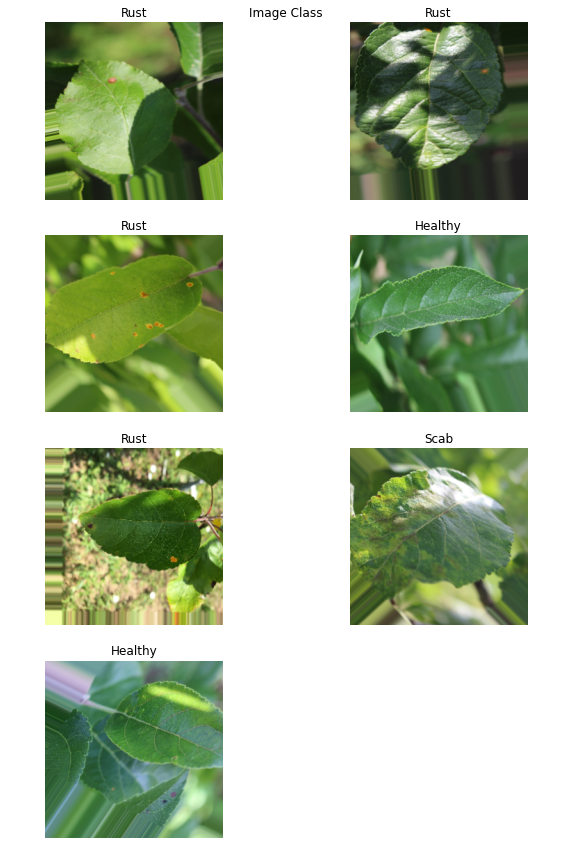

In [ ]:
fig = plt.figure(figsize=(10,15))
columns = 2
rows = 4
plt.title('Image Class')
plt.axis('off')
for i in range(1,columns*rows):

  image_batch, label_batch =next(iter(train_generator))
  fig.add_subplot(rows,columns,i)

  if label_batch[i][0] == 1:
        plt.title('Healthy')
  elif label_batch[i][1] == 1:
        plt.title('Multiple Disease')
  elif label_batch[i][2] == 1:
        plt.title('Rust')
  else:
        plt.title('Scab')
        
  plt.imshow(image_batch[i])
  plt.axis('off')
plt.show()




DenseNet121

In [ ]:
xception_model = tf.keras.models.Sequential([
  tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(256, 256, 3)),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(4,activation='softmax')
])
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
densenet_model = tf.keras.models.Sequential([
    tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',input_shape=(256, 256, 3),),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(4,activation='softmax')
   
])

#densenet_model.layers.trainable =False
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_10  (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))

xception_output = xception_model(inputs)
densenet_output = densenet_model(inputs)

outputs = tf.keras.layers.average([densenet_output, xception_output])


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 4)            7041604     input_20[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 4)            20869676    input_20[0][0]                   
__________________________________________________________________________________________________
average_4 (Average)             (None, 4)            0           sequential_14[0][0]              
                                                                 sequential_7[1][0]    

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
# Model training 
model_history = model.fit_generator(train_generator, epochs=50, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/50
73/73 [==============================] - 835s 11s/step - loss: 0.4999 - accuracy: 0.8434 - val_loss: 4.4609 - val_accuracy: 0.3452
Epoch 2/50
73/73 [==============================] - 148s 2s/step - loss: 0.4628 - accuracy: 0.8674 - val_loss: 1.3396 - val_accuracy: 0.7918
Epoch 3/50
73/73 [==============================] - 150s 2s/step - loss: 0.3232 - accuracy: 0.9018 - val_loss: 1.0252 - val_accuracy: 0.6110
Epoch 4/50
73/73 [==============================] - 148s 2s/step - loss: 0.3024 - accuracy: 0.8990 - val_loss: 0.5736 - val_accuracy: 0.8603
Epoch 5/50
73/73 [==============================] - 148s 2s/step - loss: 0.2980 - accuracy: 0.9025 - val_loss: 0.4506 - val_accuracy: 0.8685
Epoch 6/50
73/73 [==============================] - 150s 2s/step - loss: 0.2862 - accuracy: 0.9135 - val_loss: 0.4955 - val_accuracy: 0.8493
Epoch 7/50
73/73 [==============================] - 148s 2s/step - loss: 0.2535 - accuracy: 0.9148 - val_loss: 0.7668 - val_accuracy: 0.8219
Epoch 8/50
7

In [ ]:
def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['accuracy'])), history['accuracy'], 'r')
  plt.plot(np.arange(1, len(history['val_accuracy'])+1), history['val_accuracy'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model


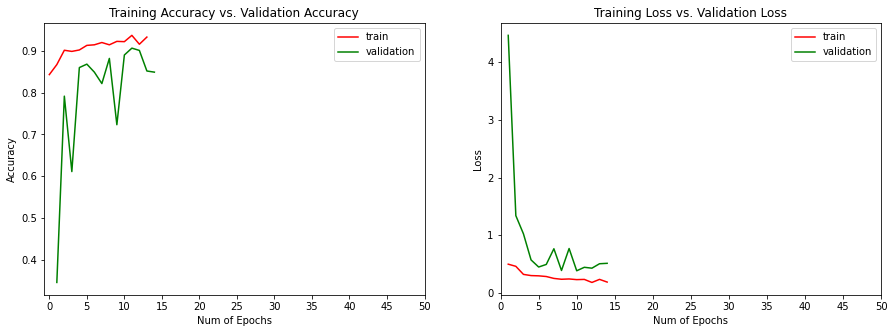

In [ ]:
plot_model_history('model', model_history.history, 50)

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = "drive/My Drive/ML Projects/Plant Pathology"
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [ ]:
save_model(model, suffix="model_info")

Saving model to: drive/My Drive/ML Projects/Plant Pathology-model_info.h5...


'drive/My Drive/ML Projects/Plant Pathology-model_info.h5'

In [ ]:
model_new = load_model('drive/My Drive/ML Projects/Plant Pathology-model_info.h5')

Loading saved model from: drive/My Drive/ML Projects/Plant Pathology-model_info.h5


In [ ]:
df =pd.DataFrame(model_new.history).to_csv('ModelHistory.csv')

In [ ]:
# Adding .jpg extension to image_id
test['image_id'] = test['image_id']+'.jpg'

In [ ]:
test_gen = valid_datagen.flow_from_dataframe(test, 
                    images,
                    x_col='image_id',
                    target_size=(512, 512), 
                    class_mode=None,
                    shuffle=False,
                    batch_size=8)

Found 1821 validated image filenames.


In [ ]:
predictions = model_new.predict_generator(test_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
sub['healthy'] = predictions[:, 0]
sub['multiple_diseases'] = predictions[:, 1]
sub['rust'] = predictions[:, 2]
sub['scab'] = predictions[:, 3]

In [ ]:
sub.to_csv('drive/My Drive/ML Projects/Plant Pathology/submission.csv', index=False)